Codes to produce the plots for season characteristics submitted to 
the `How not to forecast the flu` paper.

**Table of contents**

1. [Between Surveillance Deviations](#Surveillance-deviations)
2. [Within Surveiillance Deviations](#Strain-deviations)
3. [Instability of surveillance](#Surveillance-Instability)
4. [Drop off of surveillance](#Surveillance-Drop-off)

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

fs, lw, style = 12, 1.5, 'fivethirtyeight'

In [3]:
cdc_data = pd.read_csv('./data/cdc-combined-national-2015-05-25.csv',
                      index_col=0, parse_dates=True)

# Surveillance Deviations

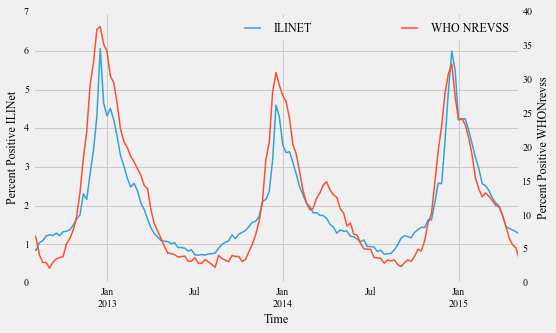

In [4]:
with plt.style.context((style)):
    fig1, ax1 = plt.subplots(figsize=(8, 5))

    cdc_data.ix['2012-08':, '% WEIGHTED ILI'].plot(ax=ax1, lw=lw)
    
    cdc_data.ix['2012-08':, 'PERCENT POSITIVE'].plot(ax=ax1, 
                                                    secondary_y=True,
                                                     lw=lw)
    
    ax1.legend(['ILINET'], loc='upper center', fontsize=fs)
    ax1.right_ax.legend(['WHO NREVSS'], loc='upper right', fontsize=fs)
    
    ax1.set_ylabel('Percent Positive ILINet', fontsize=fs)
    ax1.right_ax.set_ylabel('Percent Positive WHONrevss', fontsize=fs)
    ax1.set_xlabel('Time')
    
    fig1.tight_layout()
    fig1.savefig('./figures/ilinet_vs_nrevss.png', dpi=300, 
                 facecolor=fig1.get_facecolor())

# Strain Deviations

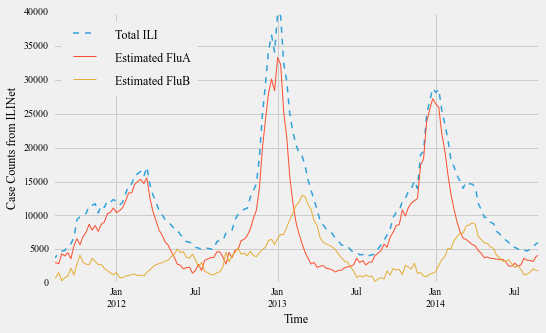

In [5]:
with plt.style.context((style)):
    fig2, ax2 = plt.subplots(figsize=(8, 5))

    
    cdc_data.ix['2011-08': '2014-08', ['ILITOTAL']].fillna(0).plot(ax=ax2, lw=lw, 
                                                                      style='--')
    cdc_data.ix['2011-08':'2014-08', ['ILI_FLUA', 'ILI_FLUB']].fillna(0).plot(ax=ax2, lw=1)
    
    ax2.legend(['Total ILI', 'Estimated FluA', 'Estimated FluB'], loc='best')
    ax2.set_ylabel('Case Counts from ILINet')
    ax2.set_xlabel('Time')
    
    fig2.tight_layout()
    fig2.savefig('./figures/ilinet_subtyped.png', dpi=300, 
                 facecolor=fig2.get_facecolor())

# Surveillance Instability

Surveillance data is genrally unstable. Usually it takes a number of updates from the agency before the surveillance data gets stabilizied.
This instability can vary from one country to another (within a single 
network) as well as between networks. Here we show the instability of two different kinds of surveillance networks:

1. [PAHO](#PAHO-Instability): FluNet network for ILI (a lab based system)
2. [CDC](#CDC-Instability): ILINet network for ILI (an outpatient reporting system)

As can be seen both networks show surveillance instability.

## PAHO-Instability

PAHO provides lab based surveillance feeds. We show the phenomenon of 
`surveillance drop-off` on this network. PAHO updates for several Latin American countries were collected daily from `2012-10` to `2013-10`.
ILI estimates are generally updated at irregular intervals. We assumed the estimate for a particular country for an epi week as avialable from the last update as the true value and calculated percentage relative error as:

$$ \text{Error} = \frac{\text{data} - \text{last_update}}{\text{last_update}}$$


As can be seen in the figure countries fall nicely in two groups as slowly stabilizing countries  (such as `Colombia` and `Peru`) and quickly stabilizing countries (such as `Argentina` and `El Salvador`).

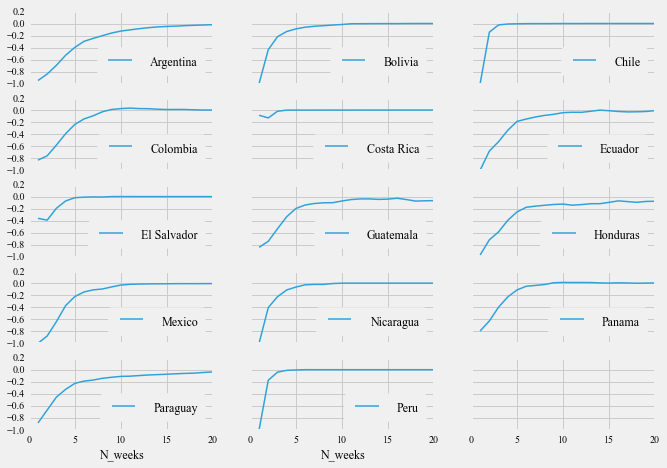

In [6]:
def return_scores(individual_group, eps=.00001):
    tmp = individual_group.copy()
    final_value = tmp.sort('N_weeks').iloc[-1, :]['ILI']
    final_value = final_value + eps
    tmp['qs'] = tmp.ILI.apply(lambda x: 4 * (1 - np.abs(x - final_value)/ np.max((x, final_value, 10))))
    tmp['rel_err'] = (tmp.ILI - final_value) / final_value 
    tmp['abs_rel_err'] = tmp['rel_err'].abs()
    # tmp.drop_duplicates(inplace=True)
    return tmp

act_countries = ['Argentina', 'Bolivia', 'Chile', 'Colombia',
                 'Costa Rica', 'Ecuador', 'El Salvador',
                 'Guatemala', 'Honduras', 'Mexico',
                 'Nicaragua', 'Panama', 'Paraguay', 'Peru']

with plt.style.context((style)):
    fig3, ax3 = plt.subplots(5, 3, figsize=(10, 7), 
                             sharex=True, sharey=True)
    for idx_ct, ct in enumerate(act_countries):
        ax = ax3.flatten()[idx_ct]
        df = pd.read_excel('./data/PAHO_2013-10-10.xlsx', sheetname=ct)
        df.ILI = df.ILI.astype(float)
        
        groups = df.groupby('Date')
        
        scored_df = pd.DataFrame()
        for name, group in df.groupby('Date', as_index=False):
            scored_df = pd.concat((scored_df, return_scores(group)))

        instability = scored_df.groupby('N_weeks').agg({"qs": np.nanmean, "rel_err": np.nanmean,
                                                        "abs_rel_err": np.nanmean})
        instability.rel_err.plot(ax=ax, lw=lw)
        ax.set_xlim([0, 20])
        ax.legend([ct], loc='lower right')
        

In [7]:
fig3.tight_layout()
fig3.savefig('./figures/ili_updates.png', dpi=300, 
             facecolor=fig3.get_facecolor())

## CDC Instability

CDC historical updates for national regions can be accessed from [ <SEASON>/data/senAllregt<EpiWeek>.htm](http://www.cdc.gov/flu/weekly/weeklyarchives2013-2014/data/senAllregt09.htm) (click on the link for an example)

In [4]:
historical_cdc = pd.read_csv('./data/cdc-historical-2010-2015.csv', 
                             na_values=['x'], 
                             dtype={'season': np.int, 'Week': np.int},
                             parse_dates=True)
historical_cdc.date = pd.to_datetime(historical_cdc.date)
historical_cdc.date_reported = pd.to_datetime(historical_cdc.date_reported)

# ***************************************************************
#                    Finding final value of ILI
# ***************************************************************

ILI_COL = 'WeightedILI'
FINAL_COL = final_col = '{}_Final'.format(ILI_COL)

def find_stable(df, ili_col=ILI_COL, final_col=FINAL_COL):
    """Function to get the stable value based on last reported date"""
    df[final_col] = df.ix[df['date_reported'].idxmax(), ili_col]
    return df

stable_cdc = historical_cdc.groupby(['date']).apply(find_stable)

# ***************************************************************
#       Calculating score of updates w.r.t final value
# ***************************************************************
x = stable_cdc[FINAL_COL]
y = stable_cdc[ILI_COL]

max_xy = pd.concat((x, y), axis=1).max(axis=1).astype('float')
# max_xy[max_xy < 10.] = 10. Not using for percent data

stable_cdc['QS'] = 4 * (1 - (x - y).abs() / max_xy)

stable_cdc['rel_err'] = (y - x) / x
stable_cdc['abs_rel_err'] = stable_cdc['rel_err'].abs()

stable_cdc['reporting_delay'] = (stable_cdc['date_reported'] 
                                 - stable_cdc['date']).dt.days // 7
# Removing spurious values
stable_cdc = stable_cdc[stable_cdc.reporting_delay >= 0]

We can plot the relative error of updates as a scatter plot as shown below. 
The mean relative error for each update is also shown below. As can be seen,
similar to PAHO a few updates is required before the value stabilizies. However, 
CDC data for USA is found to be `fast stabilizing`. 

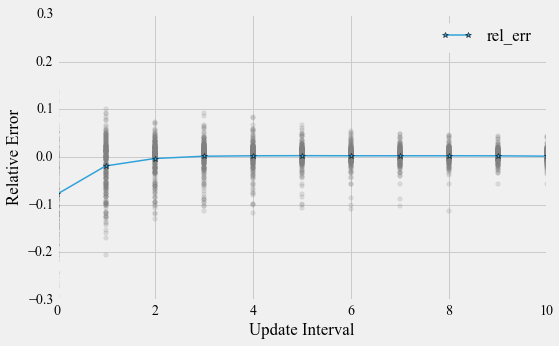

In [112]:
with plt.style.context((style)):
    fig7, ax7 = plt.subplots(figsize=(8, 5))
    stable_cdc.plot(x='reporting_delay', y='rel_err', ax=ax7,
                    kind='scatter', color='grey', alpha=0.2)
    mean_stable = stable_cdc.groupby('reporting_delay').mean()
    mean_stable['rel_err'].plot(ax=ax7, lw=lw, style='-*')
    ax7.set_ylabel('Relative Error')
    ax7.set_xlabel('Update Interval')
    ax7.set_xlim([0, 10])
    ax7.set_ylim([-0.3, 0.3])
    ax7.legend()
    fig7.tight_layout()
    fig7.savefig('./figures/cdc_instability.png', dpi=300)

### Animated CDC

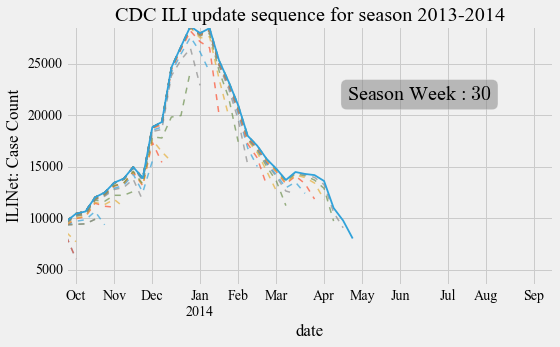

In [10]:
from matplotlib import animation

def animate(nframe, df, x='date', y=ILI_COL, 
            z='date_reported_week'):
    
    # set alpha of current lines
    ax = plt.gca()
    for l in ax.lines:
        l.set_alpha(0.7)
        l.set_linestyle('--')
        l.set_linewidth(lw)
    # removing textboxes
    for txt in ax.texts:
        txt.remove()
        
    plt_series = pd.Series(index=df[x].drop_duplicates())
    known_df = df[df[z] == (nframe + 1)]
    known_series = known_df.drop_duplicates(x).set_index(x)[y]
    
    plt_series = known_series.combine_first(plt_series)
    
    # goodies
    ax.set_ylim(df[y].min() - 0.1, df[y].max() + 0.1)
    
    ax.text(plt_series.index[-15], 
            df[y].max() * 3 / 4,
            "Season Week : ${}$".format(nframe + 1),
            fontsize=20, ha='center',
            bbox=dict(boxstyle='round', alpha=0.5, facecolor='grey')
           )
    # new line
    plt_series.plot(ax=ax, legend=False, lw=lw * 1.2, style='-')
    
    return

with plt.style.context((style)):
    fig8, ax8 = plt.subplots(figsize=(8,5))
    ax8.set_title('CDC ILI update sequence for season 2013-2014')
    ax8.set_ylabel('ILINet: Case Count')
    ax8.set_xlabel('date')
    
    df = historical_cdc[historical_cdc.season == 2014]
    anim = animation.FuncAnimation(fig8, animate, 30, 
                                   fargs=(df, 'date', 'TotalILI'))
    fig8.tight_layout()
    anim.save('./figures/animated_cdc.gif', writer='imagemagick', 
             fps=2)

# Surveillance Drop-off

Post-peak the surveillance efforts drops. We elucidate this by plotting the scatter plot
of the CDC ILINet reported number of providers as a function of season week. As the scatter
plot shows, the number of providers decreases sharply at around season week $33$. We identified 
this point by finding the inflection point of the averaged and smoothened CDC ILINet number of providers. 
The inflection point is also found via smotthened version to account for sporadic variations. 

In [23]:
selected_cdc = cdc_data.query('season in [2010, 2011, 2012, 2013, 2014]')

# Smoothing data
span_size = 4
avg_providers = selected_cdc.groupby('season_week').agg({'NUM. OF PROVIDERS': 'mean'})
smooth_providers = pd.ewma(avg_providers, span=span_size)

# Calculating gradients on smoothened data
provider_summary = pd.DataFrame(index=smooth_providers.index)
provider_summary['average'] = smooth_providers
provider_summary['grad2'] = np.gradient(np.gradient(smooth_providers.values.flatten()))
provider_summary['grad2sign'] = np.sign(provider_summary['grad2'])

# Calculating smoothened inflection point
provider_summary['inflect'] =  pd.rolling_sum(provider_summary['grad2sign'], 
                                              window=span_size).shift(-span_size + 1)

# Inflection point = first point where you get a sum of span_size
inflection_point = provider_summary[provider_summary['inflect'] == span_size].index[0]

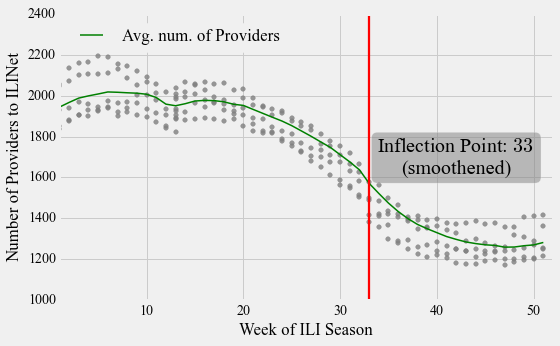

In [24]:
with plt.style.context(('fivethirtyeight')):
    fig5, ax5 = plt.subplots(figsize=(8,5))
    x_data = 'season_week'
    y_data = 'NUM. OF PROVIDERS'
    selected_cdc[[x_data, y_data]].plot(x=x_data, y=y_data,
                                        kind='scatter', ax=ax5,
                                        #alpha=0.5, color='green')
                                        alpha=0.8, color='grey')
    # avg_providers.plot(ax=ax5, lw=lw)
    smooth_providers.plot(ax=ax5, lw=lw, color='green', 
                          legend=False)
    ax5.axvline(inflection_point, lw=1.5 * lw, color='red')
    # pd.rolling_mean(avg_providers, window=4).plot(ax=ax5, lw=lw)
    ax5.legend(['Avg. num. of Providers'], loc='upper left')
    ax5.text(inflection_point + 9, 
             smooth_providers.ix[inflection_point] + 50,
             "Inflection Point: ${}$ \n(smoothened)".format(inflection_point),
             fontsize=20, ha='center',
             bbox=dict(boxstyle='round', alpha=0.5, facecolor='grey')
             )
             
    ax5.set_xlim([1, 52])
    ax5.set_ylabel('Number of Providers to ILINet')
    ax5.set_xlabel('Week of ILI Season')
    
    fig5.tight_layout()
    fig5.savefig('./figures/ili_surveillance_drop.png', dpi=300, 
                 facecolor=fig5.get_facecolor())